## Step 0. configurations

In [30]:
import warnings
warnings.filterwarnings("ignore")

## Step 1. reading data and importing libraries

In [31]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [32]:
df = pd.read_csv("../Car details v3.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


## Step 2. understanding the data

In [33]:
df.shape

(8128, 13)

In [34]:
df.columns

Index(['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In [35]:
df.index

RangeIndex(start=0, stop=8128, step=1)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [37]:
df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


## Step 2b. Feature Engineering

New column `make` derived from column `name`

In [38]:
if "name" in df.columns:
    df["make"] = df["name"].str.split(" ").str.get(0)
    df.drop(columns=["name"], inplace=True)

New columns `age_of_car` derived from column `year`

In [39]:
import datetime
current_year = datetime.datetime.now().year

df["age_of_car"] = df["year"].apply(lambda x: current_year - x)

New column `mileage_per_year` derived from columns `km_driven` and `age_of_car`

In [40]:
df["mileage_per_year"] = df["km_driven"] / df["age_of_car"]

New column `engine_cc`, derived from `engine` to just contain the numeric value instead of a string ending with "CC"

In [41]:
if "engine" in df.columns:
    df["engine_cc"] = df["engine"].str.split(" ").str.get(0).fillna(0).astype(int)
    df = df.drop(columns=["engine"], axis=1)

New column `power_to_weight_ratio` derived from column `max_power` and `seats`

In [42]:
if "max_power" in df.columns:
    df["max_power_bhp"] = df["max_power"].str.split(" ").str.get(0).replace('', '0').astype(float)
    df = df.drop(columns=["max_power"], axis=1)

df["power_to_weight_ratio"] = df["max_power_bhp"] / df["seats"]

New column `fuel_efficiency` derived from column `mileage`

In [43]:
if "mileage" in df.columns:
    df["fuel_efficiency"] = df["mileage"].str.split(" ").str.get(0).replace('', '0').astype(float)
    df = df.drop(columns=["mileage"], axis=1)

One-hot-encode column `transmission` to be categorical

In [44]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

if "transmission" in df.columns:
    df["transmission_manual"] = encoder.fit_transform(df["transmission"])
    df = df.drop(columns=["transmission"], axis=1)

Drop column `torque`, because it's formatted too complicated

In [45]:
if "torque" in df.columns:
    df = df.drop(columns=["torque"], axis=1)

Convert column `owner` to be numerical

In [46]:
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 0  # Assuming this represents the least ownership
}

if "owner" in df.columns:
    df["previous_owners"] = df["owner"].map(owner_mapping)
    df = df.drop(columns=["owner"], axis=1)

One-hot-encode columns `fuel`, `seller_type` and `make` to be categorical

In [47]:
columns_to_encode = ['fuel', 'seller_type', 'make']

for column in columns_to_encode:
    if column in df.columns:
        df = pd.get_dummies(df, columns=[column], dtype="int64")

In [48]:
df.head(1)

,year,selling_price,km_driven,seats,age_of_car,mileage_per_year,engine_cc,max_power_bhp,power_to_weight_ratio,fuel_efficiency,...,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
0,2014,450000,145500,5.0,10,14550.0,1248,74.0,14.8,23.4,...,0,0,0,0,0,0,0,0,0,0


## Step 3. Visualizing

For visualization I am using the original Dataset again instead of the Feature Engineered dataset.

In [49]:
data = pd.read_csv("../Car details v3.csv")

In [50]:
data.head(1)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0


In [51]:
numerical_columns = data.select_dtypes(include="number").columns \
    .drop("seats")

numerical_columns

Index(['year', 'selling_price', 'km_driven'], dtype='object')

In [52]:
categorical_columns = data.select_dtypes(include="object").columns \
    .drop(["name", "mileage", "engine", "max_power", "torque"]) \

# add "seats" column to categorical_columns
categorical_columns = categorical_columns.append(pd.Index(["seats"]))

categorical_columns

Index(['fuel', 'seller_type', 'transmission', 'owner', 'seats'], dtype='object')

In [53]:
boolean_columns = data.select_dtypes(include="bool").columns
boolean_columns

Index([], dtype='object')

### **Distributions**

Numerical columns

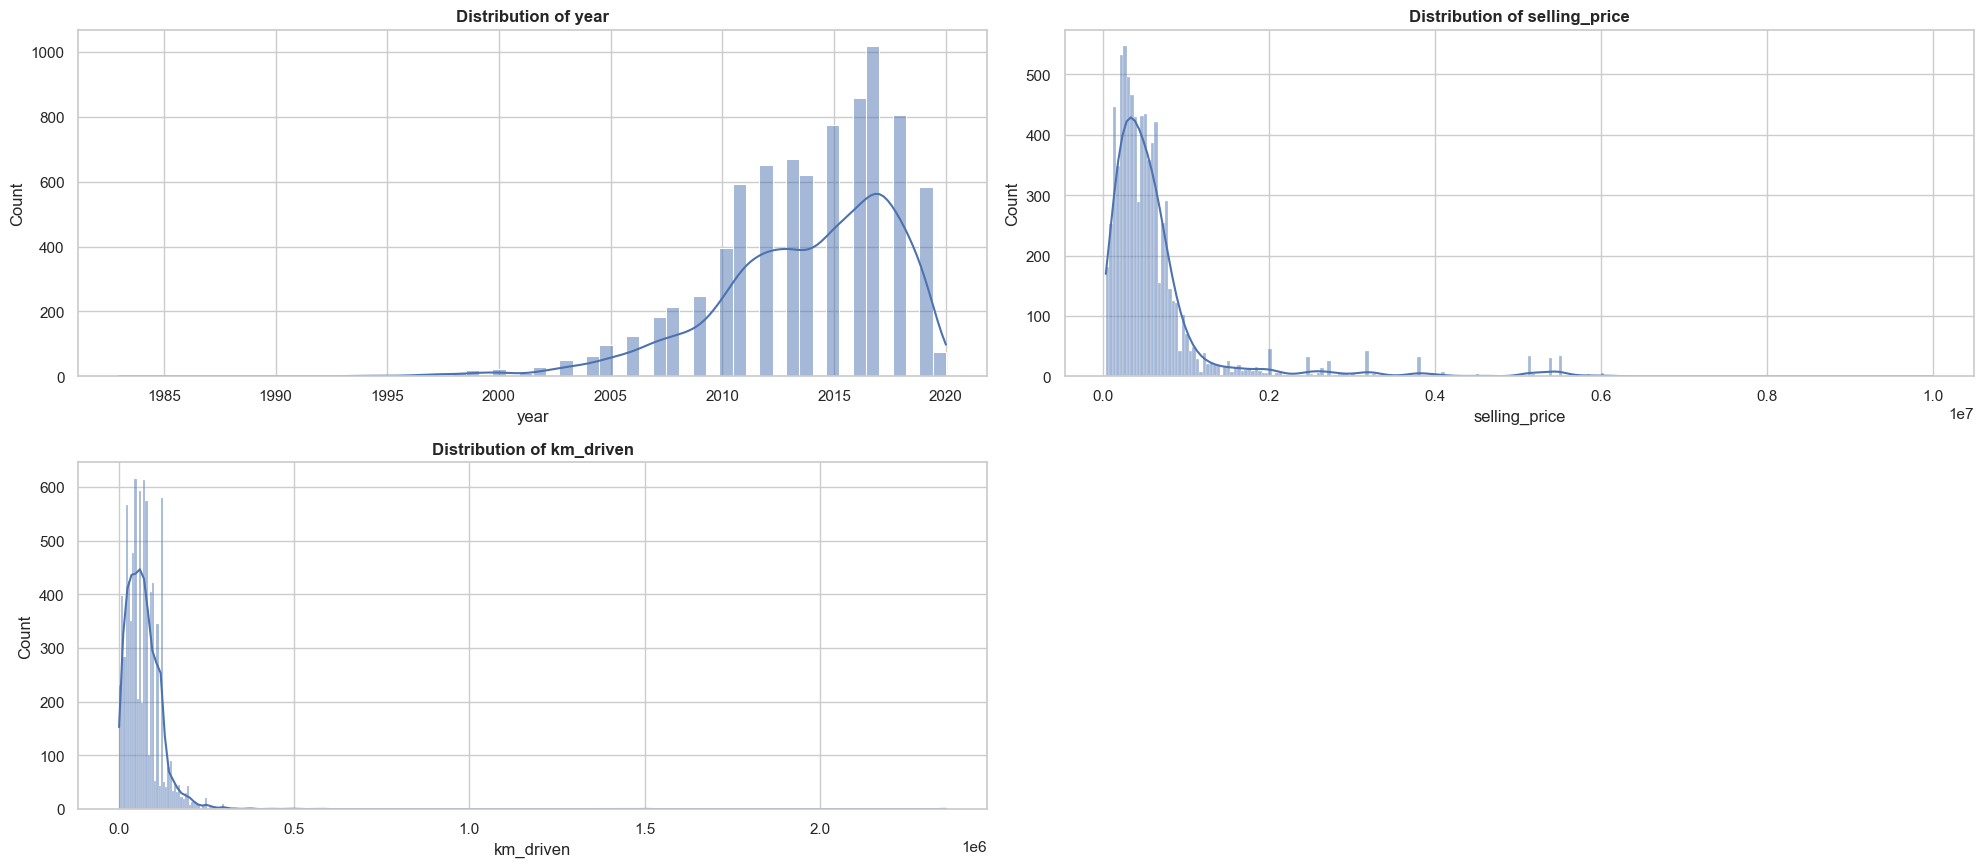

In [54]:
plt.figure(figsize=(20, 30))

for i, column in enumerate(numerical_columns):
    plt.subplot(len(data.columns)//2 + len(data.columns)%2, 2, i+1)
    sns.histplot(data[column], kde=True)
    plt.title(f"Distribution of {column}", fontweight="bold")

plt.tight_layout()
plt.show()

Categorical columns

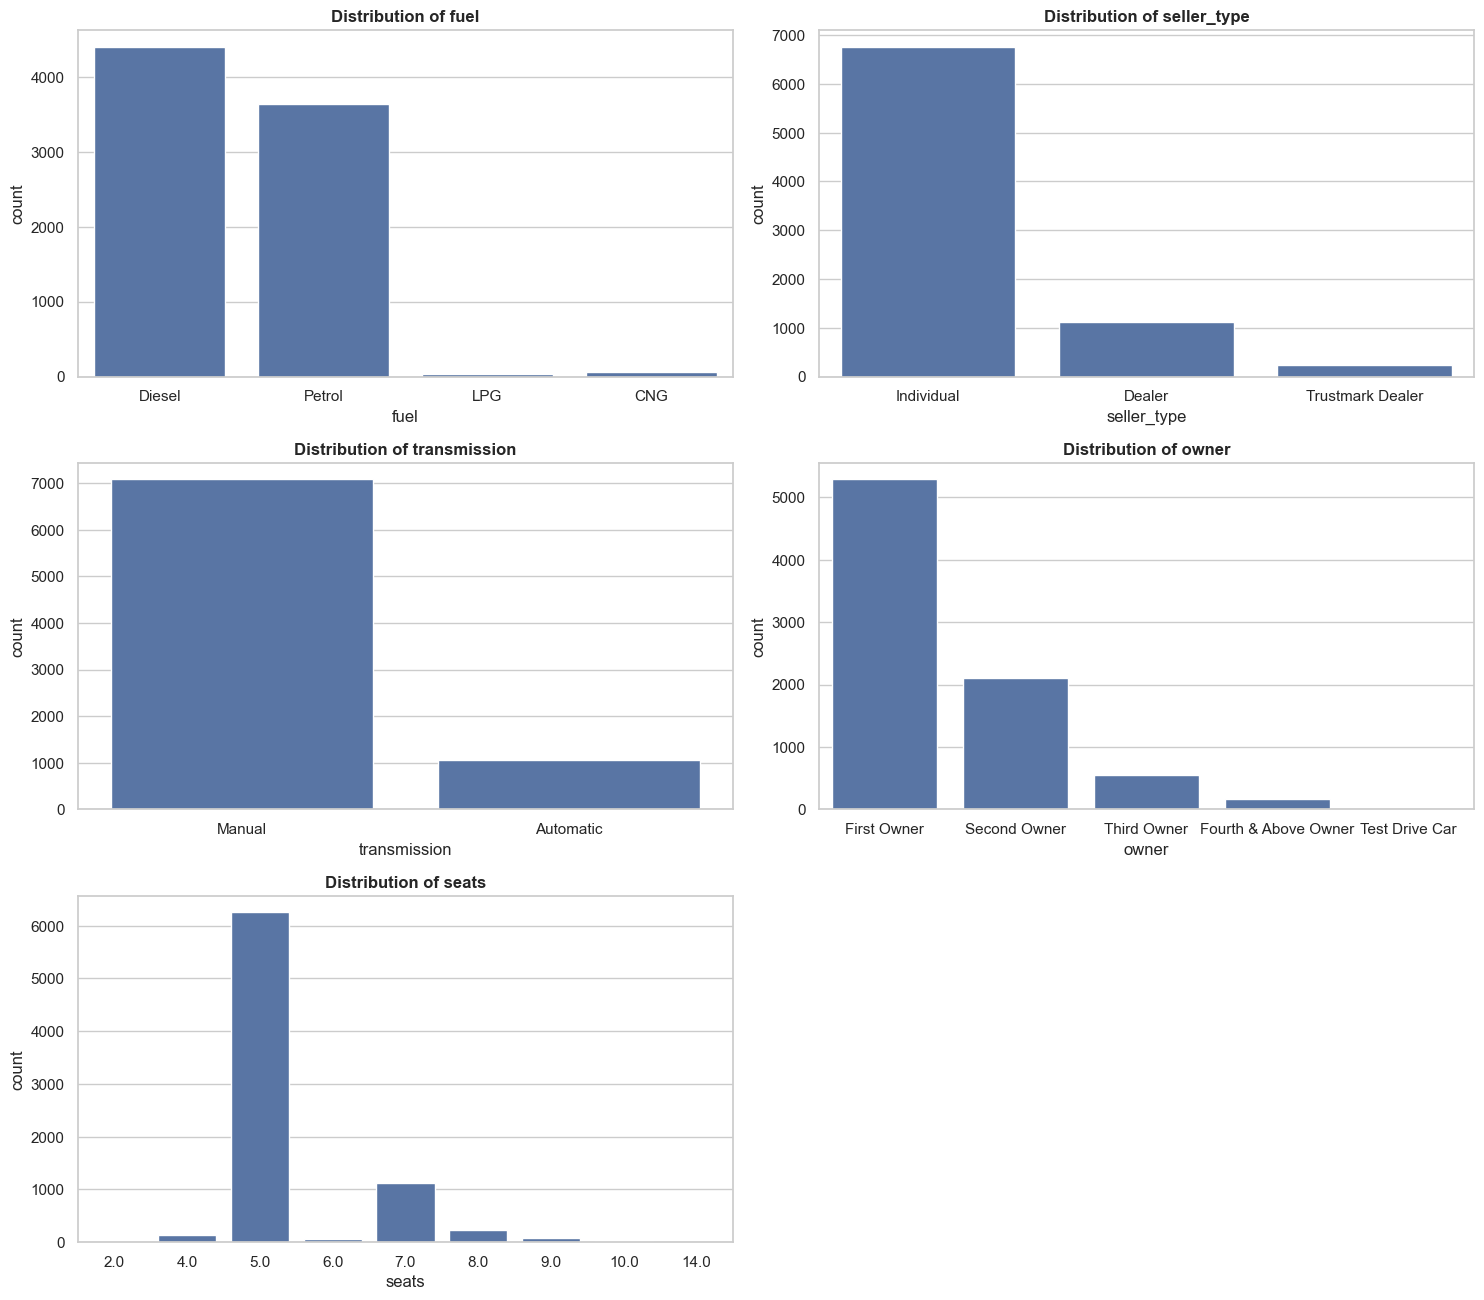

In [55]:
plt.figure(figsize=(15, 30))

for i, column in enumerate(categorical_columns):
    plt.subplot(len(data.columns)//2 + len(data.columns)%2, 2, i+1)
    sns.countplot(data=data, x=data[column])
    plt.title(f"Distribution of {column}", fontweight="bold")

plt.tight_layout()
plt.show()

Boolean columns

In [56]:
plt.figure(figsize=(15, 60))

for i, column in enumerate(boolean_columns):
    plt.subplot(len(data.columns)//2 + len(data.columns)%2, 2, i+1)
    sns.countplot(data=data, x=data[column])
    plt.title(f"Distribution of {column}", fontweight="bold")

plt.tight_layout()
plt.show()

<Figure size 1500x6000 with 0 Axes>

### **Correlations**

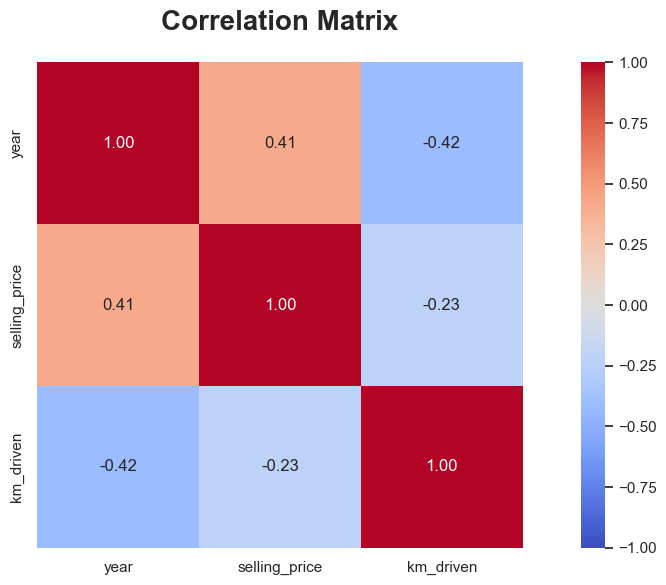

In [57]:
correlation_matrix = data[numerical_columns].corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, 
    annot=True, 
    square=True, 
    cmap="coolwarm", 
    fmt=".2f",
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix", fontweight="bold", fontsize=20, y=1.05)

plt.tight_layout()
plt.show()

### **Outliers**

Text(0.5, 1.0, 'Boxplot for Numerical Columns')

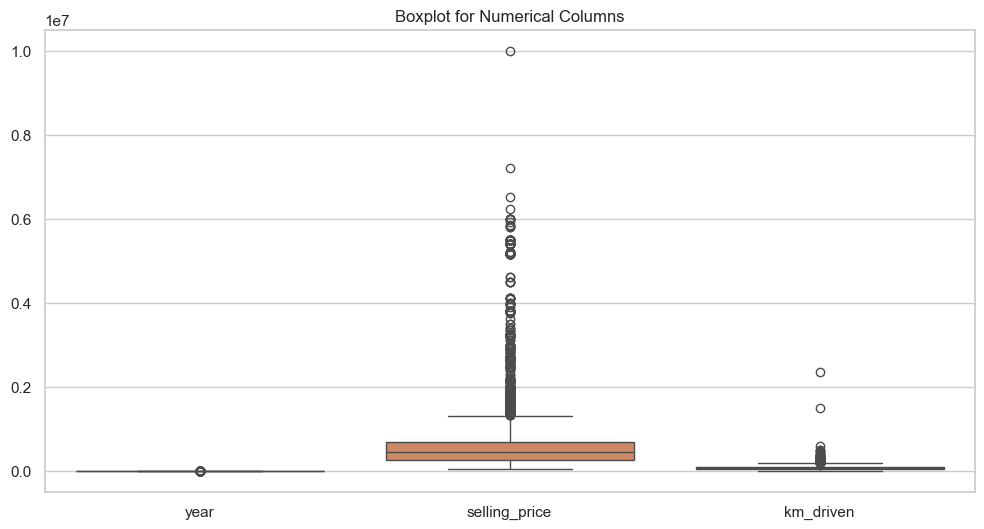

In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numerical_columns])
plt.title("Boxplot for Numerical Columns")


## Step 4. Deal with missing values

In [59]:
def show_missing_count():
    missing_df = pd.DataFrame(df.isna().sum(), columns=["missing_count"])
    missing_df = missing_df[missing_df["missing_count"] > 0]

    return missing_df

show_missing_count()

,missing_count
seats,221
max_power_bhp,215
power_to_weight_ratio,221
fuel_efficiency,221


Deal with column `seats`

In [60]:
df.seats.fillna(df.seats.median(), inplace=True)
show_missing_count()

,missing_count
max_power_bhp,215
power_to_weight_ratio,221
fuel_efficiency,221


Deal with column `max_power_bhp`

In [61]:
df.max_power_bhp.fillna(df.max_power_bhp.median(), inplace=True)
show_missing_count()

,missing_count
power_to_weight_ratio,221
fuel_efficiency,221


Deal with column `power_to_weight_ratio`

In [62]:
df.power_to_weight_ratio.fillna(df.power_to_weight_ratio.median(), inplace=True)
show_missing_count()

,missing_count
fuel_efficiency,221


In [63]:
df.fuel_efficiency.fillna(df.fuel_efficiency.median(), inplace=True)
show_missing_count()

,missing_count


## Step 5: Modelling

The goal for this dataset is to create a regression model that can predict the column `selling_price`

### Import modelling libraries

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### train_test_split

In [65]:
df.columns

Index(['year', 'selling_price', 'km_driven', 'seats', 'age_of_car',
       'mileage_per_year', 'engine_cc', 'max_power_bhp',
       'power_to_weight_ratio', 'fuel_efficiency', 'transmission_manual',
       'previous_owners', 'fuel_CNG', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol',
       'seller_type_Dealer', 'seller_type_Individual',
       'seller_type_Trustmark Dealer', 'make_Ambassador', 'make_Ashok',
       'make_Audi', 'make_BMW', 'make_Chevrolet', 'make_Daewoo', 'make_Datsun',
       'make_Fiat', 'make_Force', 'make_Ford', 'make_Honda', 'make_Hyundai',
       'make_Isuzu', 'make_Jaguar', 'make_Jeep', 'make_Kia', 'make_Land',
       'make_Lexus', 'make_MG', 'make_Mahindra', 'make_Maruti',
       'make_Mercedes-Benz', 'make_Mitsubishi', 'make_Nissan', 'make_Opel',
       'make_Peugeot', 'make_Renault', 'make_Skoda', 'make_Tata',
       'make_Toyota', 'make_Volkswagen', 'make_Volvo'],
      dtype='object')

In [66]:
X = df.drop(columns=["selling_price"])
y = df["selling_price"]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [68]:
scaler = MinMaxScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_stand, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_stand, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [69]:
# Create dataset and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

### **PyTorch Model Architecture**

### 1. Architecture

In [70]:
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.fc4 = nn.Linear(100, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation (linear output for regression)
        return x

### 2. Initialisation phase

In [72]:
# Initialise the model, loss function, and optimiser
input_size = X_train_stand.shape[1]
model = RegressionModel(input_size)

criterion = nn.MSELoss()   # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3. Training loop

In [74]:
num_epochs = 500
patience = 500
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict()  # Save the best model
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping at epoch", epoch)
        model.load_state_dict(best_model_state)
        break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}:\ttrain_loss - {train_loss:.4f}, val_loss - {val_loss:.4f}")

Epoch 0:	train_loss - 1054953314745.7255, val_loss - 985608235048.1569
Epoch 10:	train_loss - 1046093747862.5883, val_loss - 976294670576.9412
Epoch 20:	train_loss - 1035318021662.1177, val_loss - 965117615003.6078
Epoch 30:	train_loss - 1022568997506.5098, val_loss - 955196818371.7646
Epoch 40:	train_loss - 1008736780769.8823, val_loss - 931727561105.5686
Epoch 50:	train_loss - 1076411053718.5883, val_loss - 932070440317.4902
Epoch 60:	train_loss - 973038357965.8040, val_loss - 897038399287.2157
Epoch 70:	train_loss - 953905554251.2941, val_loss - 874961955819.9215
Epoch 80:	train_loss - 932732821664.6274, val_loss - 834432170425.7255
Epoch 90:	train_loss - 913152791572.0785, val_loss - 844682046443.9215
Epoch 100:	train_loss - 888669021605.6471, val_loss - 821397697716.7059
Epoch 110:	train_loss - 862719191040.0000, val_loss - 772480173959.5294
Epoch 120:	train_loss - 837617140153.7255, val_loss - 749457238377.4117
Epoch 130:	train_loss - 808202119449.0980, val_loss - 708834604694.58

### 4. Evaluation

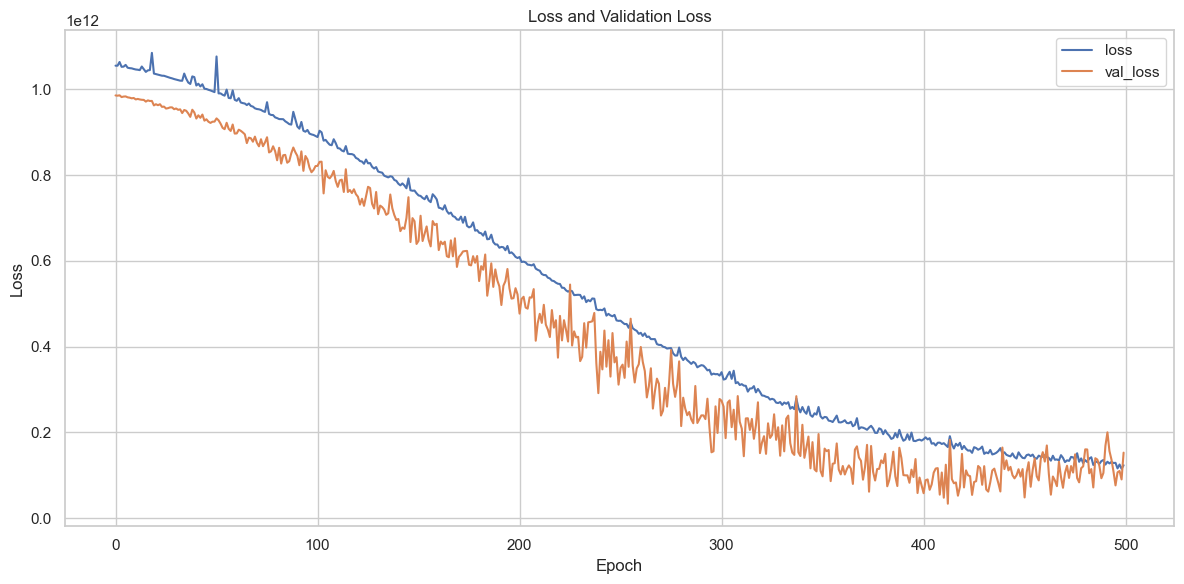

In [75]:
# Plot loss and val_loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Step 5: Evaluation

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the model on the test set
model.eval()
y_pred = []

with torch.no_grad():
	for X_batch, _ in test_loader:
		outputs = model(X_batch)
		y_pred.extend(outputs)

y_pred = torch.cat(y_pred).cpu().numpy().flatten()

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

Mean Absolute Error: 214406.84
Mean Squared Error: 152648574768.16
Root Mean Squared Error: 390702.67
R2 Score: 0.75


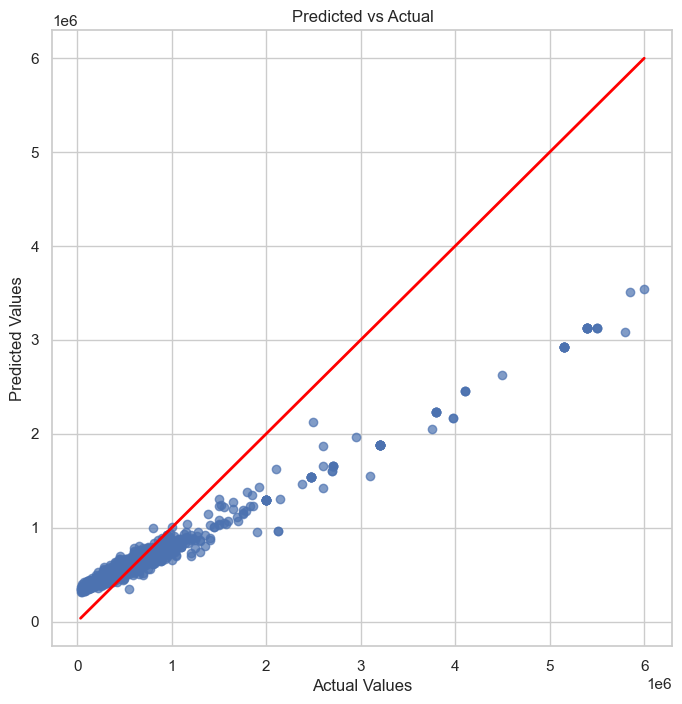

In [77]:
# Plot predicted vs actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual')
plt.show()


I knew it was going to be bad from the MSE, MAE, RMSE and R2 score, but this is just a crazy visualisation